# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday March 7th, 2022 at 23:59.

In [1]:
# Import of packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from pathlib import Path
import folium
from folium import plugins

# read police incidence reports, historical 2003 to may 2018 (files are stored in files folder of the file structure of the lecture)
police_incidence_reports = pd.read_csv(Path.cwd().parent/"files"/"Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

# preprocessing -> combiining the date and time column to a datetime column + sorting the data
police_incidence_reports['Datetime'] = pd.to_datetime(police_incidence_reports['Date']+ ' ' +\
    police_incidence_reports['Time'], format="%m/%d/%Y %H:%M")
police_incidence_reports = police_incidence_reports.sort_values(['Category', 'Datetime']).reset_index()

## Part 1: Visualizing patterns in the data

In this exercise, please generate the visualizations described below. Use the same date-ranges as in Week 2. For each set of plots, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).

We look only at the focus-crimes in the exercise below.

In [16]:
focuscrimes_set = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS',\
    'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

> *Exercise*: 
>
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. [Here's what my version looks like](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/weekdays.png). Make your own version of the plot and comment your results.
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight. Visualize and comment your results.
> * *Spatial patterns*. Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical:
>    - For each district plot the ratio `P(crime|district)/P(crime)` for the 14 focus crimes (follow and *show* the steps in Week 2 Ex. 2.2 for success).
>    - Comment on the top crimes in _Tenderloin_, _Mission_, and _Richmond_. Does this fit with the impression you get of these neighborhoods on Wikipedia?

**Weekly patterns. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. Make your own version of the plot and comment your results.**

Text(0.5, 0.98, 'N. of crimes per week-day by category')

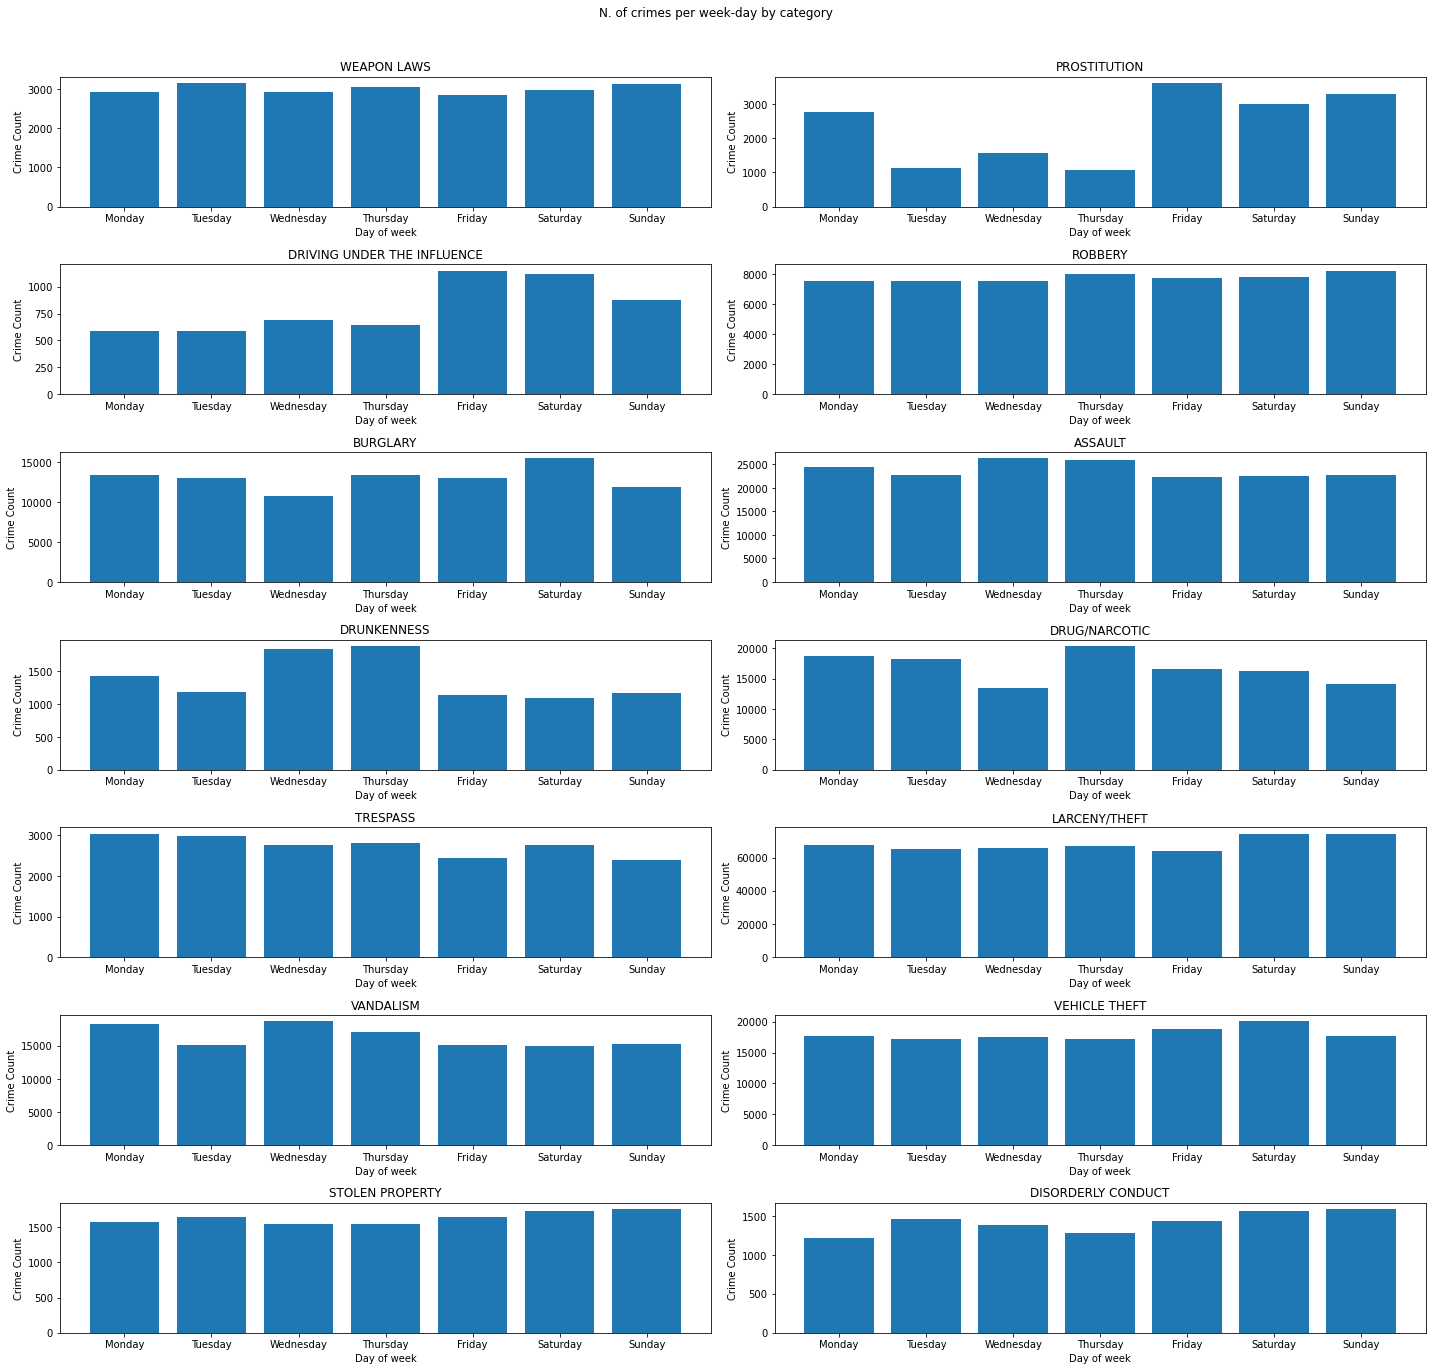

In [3]:
focuscrimes = pd.DataFrame(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', \
    'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
focuscrimes.columns = ['Category']
focuscrimes = pd.merge(focuscrimes, police_incidence_reports, on = 'Category')
focuscrimes.sort_values(by=['Category', 'Date'])

#focuscrimes by category and weekday
focuscrimes_by_category_weekday = focuscrimes.groupby(['Category', 'DayOfWeek']).agg({'PdId':'count'})\
    .sort_values(by=['Category']).rename(columns={'PdId':'Counts'}).reset_index()

day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20, 20))

m = 0
n = 0
for i in focuscrimes['Category'].unique():
    if n == 1:
        y = focuscrimes_by_category_weekday.loc[focuscrimes_by_category_weekday['Category'].isin([i])]
        axs[m,n].bar(x = day, height = y['Counts'])
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Day of week')
        axs[m,n].set_ylabel('Crime Count')
        m = m + 1
        n = 0
    else:
        y = focuscrimes_by_category_weekday.loc[focuscrimes_by_category_weekday['Category'].isin([i])]
        axs[m,n].bar(x = day, height = y['Counts'])
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Day of week')
        axs[m,n].set_ylabel('Crime Count')
        n = 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('N. of crimes per week-day by category')

The above plots show that all focus crimes do not vary a lot on day to day basis, except the prostitution and driving under the influence. Those two happen the most during Friday and weekends, which makes sense. Suprisingly, prostitution is high even on Monday. Moreover, drunkenness is the highest on Wednesday and Thursday, slightly lower on Monday, and almost the same during other days of the week.

**Hours of the week. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight. Visualize and comment your results.**

Text(0.5, 0.98, 'N. of crimes per hour of the week by category')

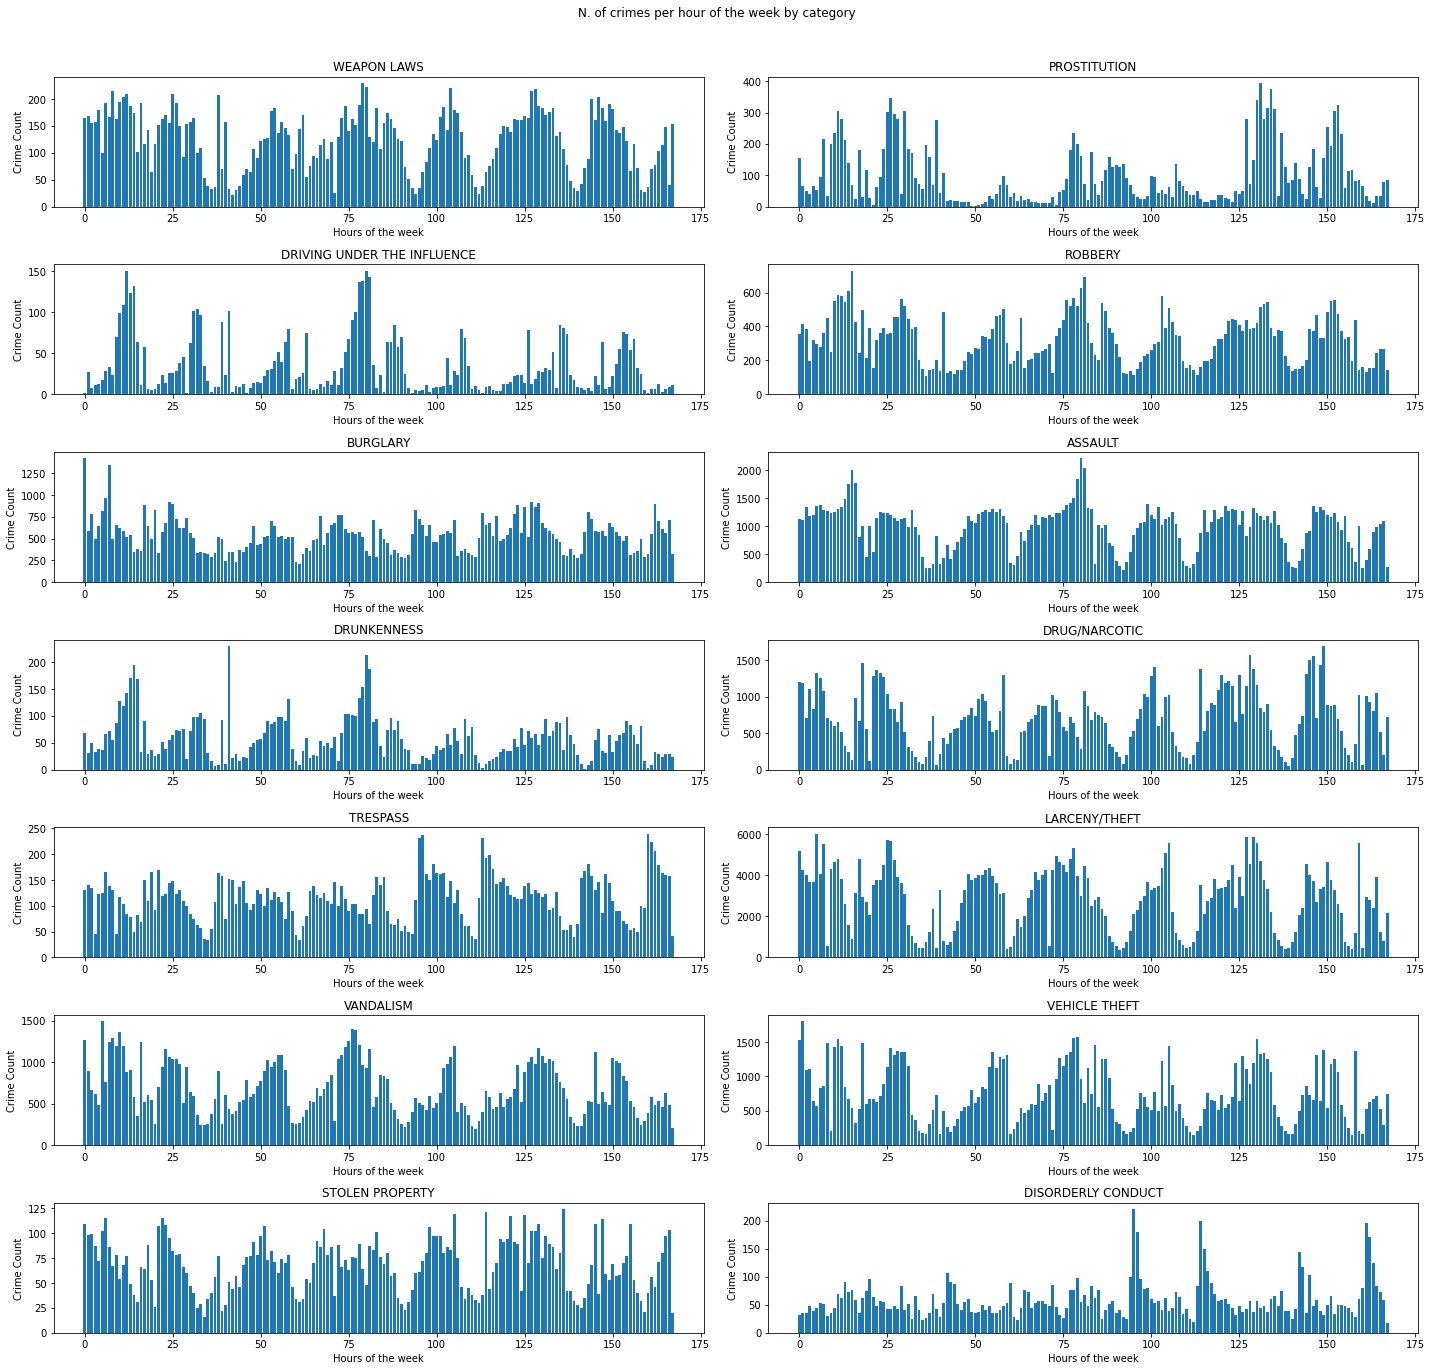

In [4]:
focuscrimes['Datetime'] = pd.to_datetime(focuscrimes['Date']+ ' ' + focuscrimes['Time'], format="%m/%d/%Y %H:%M")

focuscrimes['Hours_of_the_week'] = focuscrimes['Datetime'].dt.dayofweek * 24 + (focuscrimes['Datetime'].dt.hour + 1)

focuscrimes_by_category_hours_of_the_week = focuscrimes.groupby(['Category', 'Hours_of_the_week']).agg({'PdId':'count'})\
    .sort_values(by=['Category']).rename(columns={'PdId':'Counts'}).reset_index()

hours = range(0,168,1)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20, 20))

m = 0
n = 0
for i in focuscrimes['Category'].unique():
    if n == 1:
        y = focuscrimes_by_category_hours_of_the_week.loc[focuscrimes_by_category_hours_of_the_week['Category'].isin([i])]
        axs[m,n].bar(x = hours, height = y['Counts'])
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Hours of the week')
        axs[m,n].set_ylabel('Crime Count')
        m = m + 1
        n = 0
    else:
        y = focuscrimes_by_category_hours_of_the_week.loc[focuscrimes_by_category_hours_of_the_week['Category'].isin([i])]
        axs[m,n].bar(x = hours, height = y['Counts'])
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Hours of the week')
        axs[m,n].set_ylabel('Crime Count')
        n = 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('N. of crimes per hour of the week by category')

The above graphs are giving us better insight into the data. It can be seen that larceny/theft has the highest number of occurrences compared to the other crimes. Most crimes drop during morning hours. Burglary most occur on Monday mornings. It is interesting that drunkenness does not happen so often on weekends but more during the week, especially on Tuesdays. Disorderly conduct should be connected with vandalism and assault, somewhat with drug/narcotic and drunkenness, but from the last graph, we can see that for drunkenness this does not have to be the case. Also, while we were looking at the graphs with crimes per week-days it looked like disorderly conduct happens in the similar amout every day. However, from this point of view, based on hours of the week, we can see that is not true. Vandalism and stolen property are slightly varying through the hours but a big difference between days cannot be seen. Prostitution is the highest during night hours, but on Monday is high during the whole day, and the highest at 11 am. Hours of the week really showed the better picture of focus crimes.

**Spatial patterns. Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical:
For each district plot the ratio P(crime|district)/P(crime) for the 14 focus crimes (follow and show the steps in Week 2 Ex. 2.2 for success).
Comment on the top crimes in Tenderloin, Mission, and Richmond. Does this fit with the impression you get of these neighborhoods on Wikipedia?**

Text(0.5, 0.98, 'P(crime|district)/P(crime)')

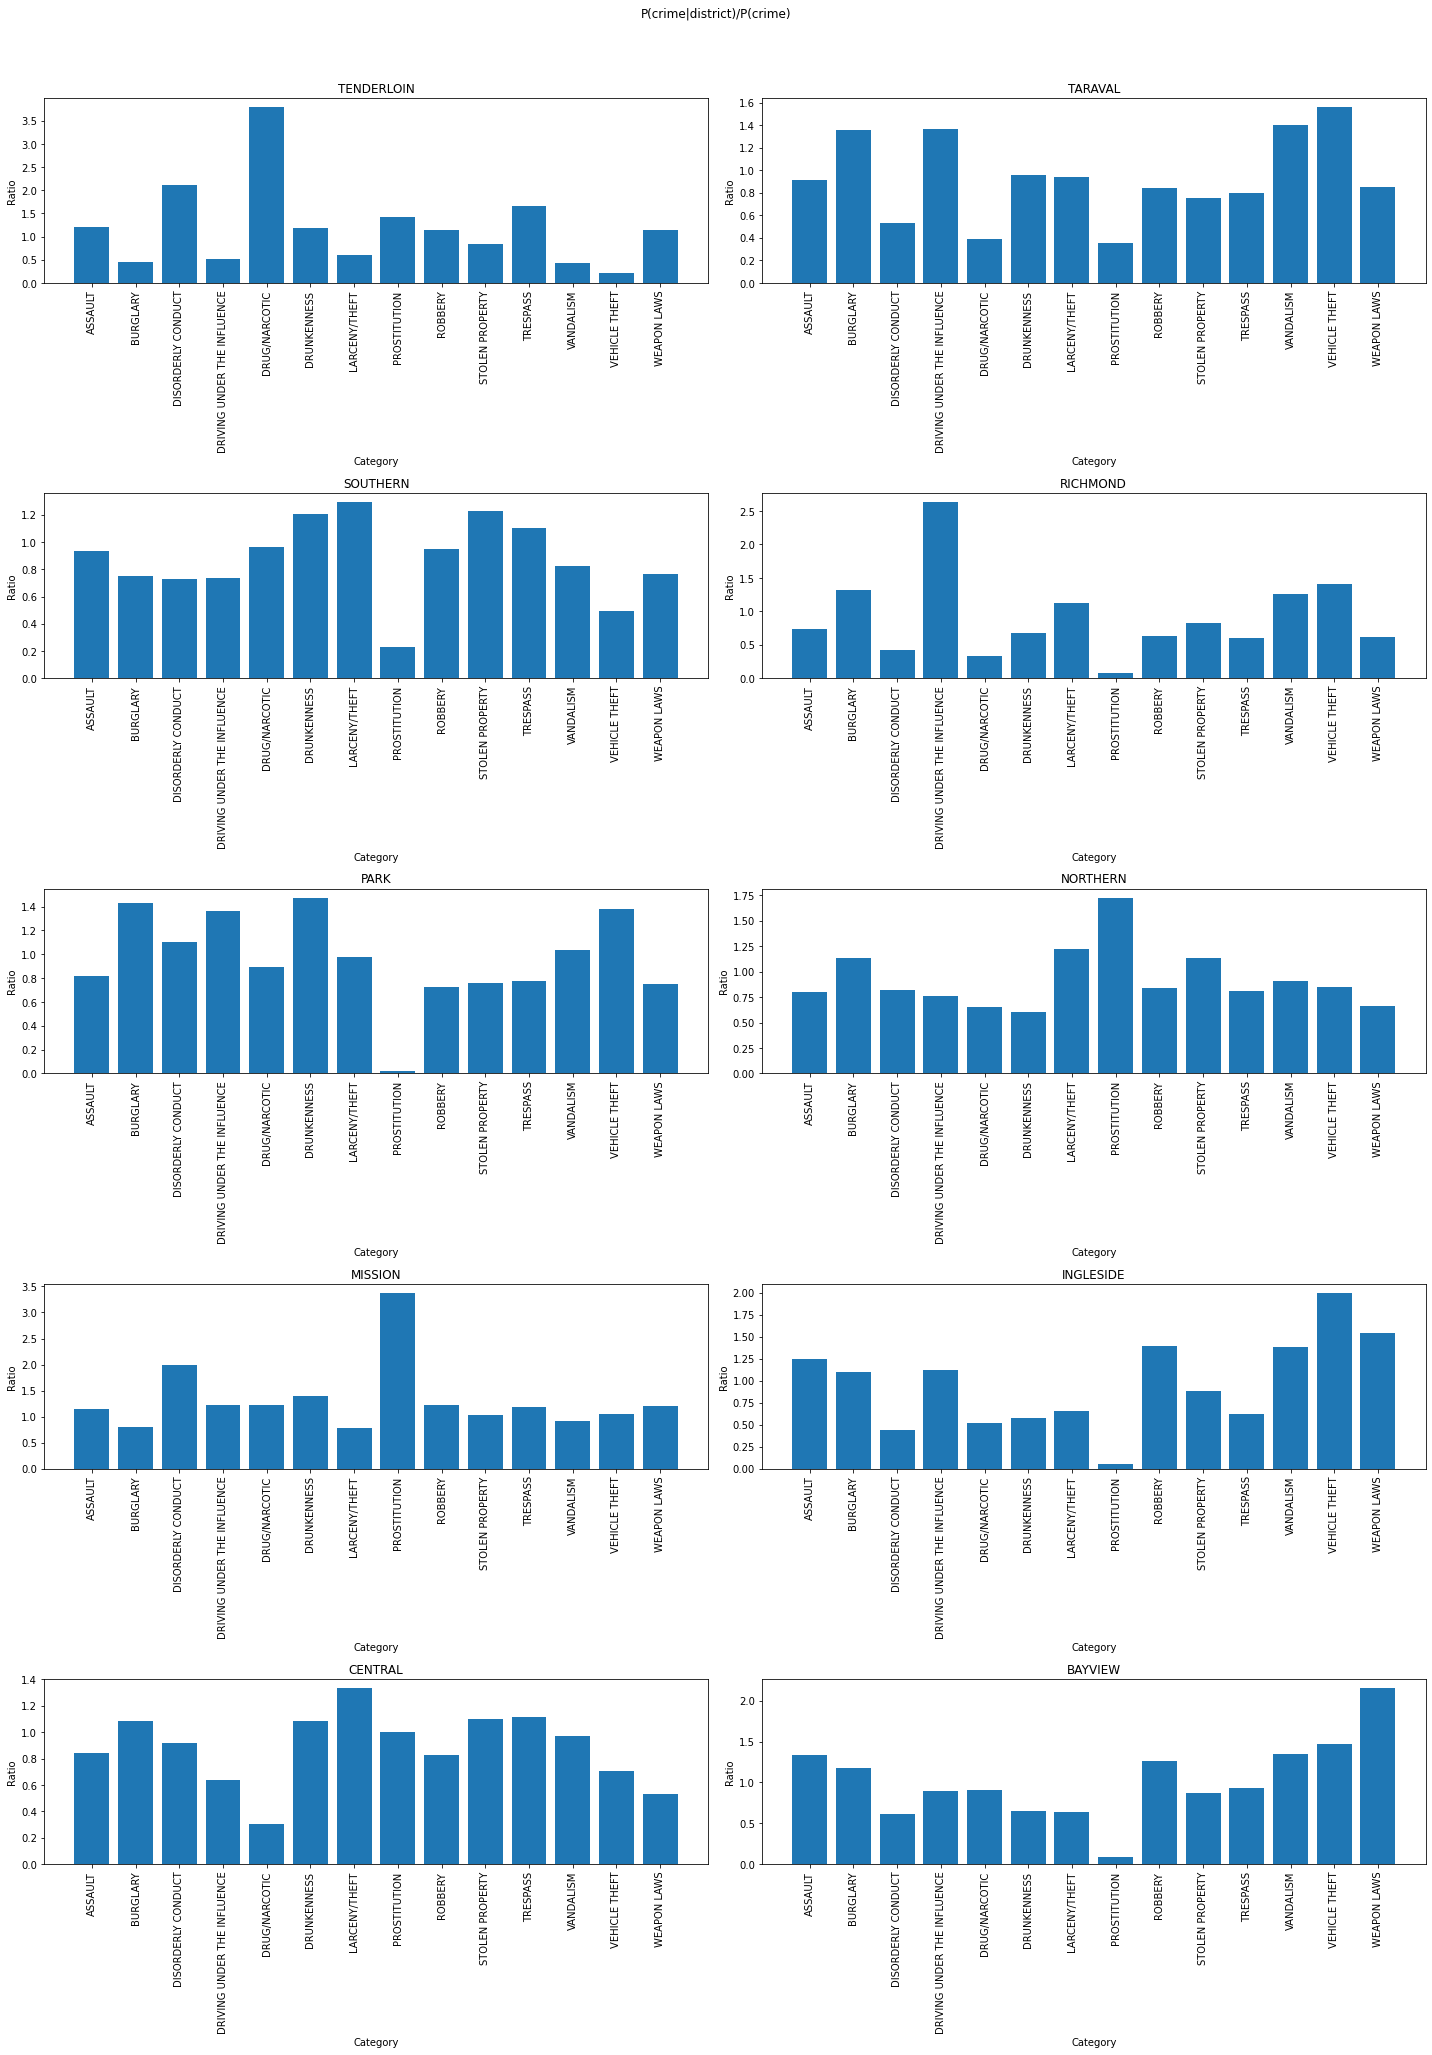

In [5]:
Police_Districts = police_incidence_reports['PdDistrict'].unique()

Police_District_most_crimes = police_incidence_reports.groupby(['PdDistrict']).agg({'PdId':'count'})\
    .sort_values(by=['PdId'], ascending = False).rename(columns={'PdId':'Counts'}).reset_index().iloc[:1]

Police_District_most_focuscrimes = focuscrimes.groupby(['PdDistrict']).agg({'PdId':'count'})\
    .sort_values(by=['PdId'], ascending = False).rename(columns={'PdId':'Counts'}).reset_index().iloc[:1]

#P(crime)

crimes_by_category = focuscrimes.groupby(['Category']).agg({'PdId':'count'})\
    .sort_values(by=['PdId'], ascending = False).rename(columns={'PdId':'Counts'}).reset_index()
sum_crimes = len(focuscrimes.index)
crimes_by_category['Counts Normalized'] = crimes_by_category['Counts']/sum_crimes

#P(crime|district)

crimes_by_category_district = focuscrimes.groupby(['Category', 'PdDistrict']).agg({'PdId':'count'})\
    .sort_values(by=['PdDistrict'], ascending = False).rename(columns={'PdId':'Counts'}).reset_index()

for i in crimes_by_category_district['PdDistrict'].unique():
    data_loop = crimes_by_category_district.loc[crimes_by_category_district['PdDistrict'].isin([i])]
    sum_crimes_loop = data_loop['Counts'].sum()
    crimes_by_category_normalized = pd.DataFrame(data_loop['Counts'].values/sum_crimes_loop)

    if i == crimes_by_category_district['PdDistrict'].unique()[0]:
        crimes_by_category_district_normalized = crimes_by_category_normalized
    else:
        crimes_by_category_district_normalized = pd.concat([crimes_by_category_district_normalized, crimes_by_category_normalized])

crimes_by_category_district_normalized = crimes_by_category_district_normalized.reset_index(drop=True)
crimes_by_category_district = pd.concat([crimes_by_category_district, crimes_by_category_district_normalized], axis=1)
crimes_by_category_district.rename(columns={0:'Counts Normalized'}, inplace=True)

#P(crime|district)/P(crime)

crimes_by_category_district = pd.merge(crimes_by_category_district, crimes_by_category, on = 'Category')
crimes_by_category_district.rename(columns={'Counts_x': 'Counts District', 'Counts Normalized_x': 'Counts Normalized District',\
    'Counts_y': 'Counts Category', 'Counts Normalized_y': 'Counts Normalized Category'}, inplace=True)
crimes_by_category_district['Ratio Normalized'] = crimes_by_category_district['Counts Normalized District']/ \
    crimes_by_category_district['Counts Normalized Category']

crimes_by_category_district.rename(columns={'Counts_x': 'Counts District', 'Counts Normalized_x': 'Counts Normalized District',\
    'Counts_y': 'Counts Category', 'Counts Normalized_y': 'Counts Normalized Category'}, inplace=True)
crimes_by_category_district['Ratio'] = crimes_by_category_district['Counts District']/crimes_by_category_district['Counts Category']

focuscrimes_category = pd.DataFrame(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
focuscrimes_category.rename(columns={0:'Category'}, inplace=True)
focuscrimes_by_category_district = pd.merge(focuscrimes_category, crimes_by_category_district, on = 'Category')
focuscrimes_by_category_district.sort_values(by=['PdDistrict', 'Category'])

#plotting 

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

m = 0
n = 0
for i in focuscrimes_by_category_district['PdDistrict'].unique():
    if n == 1:
        y = focuscrimes_by_category_district.loc[focuscrimes_by_category_district['PdDistrict'].isin([i])]
        y = y.sort_values(by = 'Category')
        axs[m,n].bar(x = np.sort(y['Category'].unique()), height = y['Ratio Normalized'])
        axs[m,n].tick_params(axis='x', rotation=90)
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Category')
        axs[m,n].set_ylabel('Ratio')
        m = m + 1
        n = 0
    else:
        y = focuscrimes_by_category_district.loc[focuscrimes_by_category_district['PdDistrict'].isin([i])]
        y = y.sort_values(by = 'Category')
        axs[m,n].bar(x = np.sort(y['Category'].unique()), height = y['Ratio Normalized'])
        axs[m,n].tick_params(axis='x', rotation=90)
        axs[m,n].set_title(i)
        axs[m,n].set_xlabel('Category')
        axs[m,n].set_ylabel('Ratio')
        n = 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('P(crime|district)/P(crime)')

The biggest crime in Tenderloin based on this dataset is drugs / narcotics, which is mentioned on Wikipedia as one of the biggest crimes. Vehicle theft is listed there as the biggest crime, while in our country it is the lowest. Attacks and burglaries are also listed as crimes that happen often, but this data set does not show them as high as they are described. Furthermore, prostitution is also high in this district, and graph does not show it very high. However, inappropriate behavior corresponds to written words. The Mission district is known by high degree of prostitution, the other crimes are not mentioned in Wikipedia, and SF dataset is showing it very high. Probably the other crimes are quite similar in number as seen in the graph. For Richmond, Wikipedia says that it is very mellow compared to other neighborhoods in San Francisco. It does have the same types of crimes that plague a lot of SF, as car break-ins, petty theft, etc. From it's graph we can see that prostitution is very low and the highest crime is driving under the influence, while theft and vehicle theft are not that high.

## Part 2: Fundamentals of data visualization

In the exercise below, there is a selection of questions from Week 3, Part 1. Please, check it out if you have any doubt on how to solve the exercise.

> *Exercise:* 
>
> * *Questions from the [lecture](https://www.youtube.com/watch?v=yiU56codNlI)*. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 
> * *Hypothesis testing*. Use [data 1](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv) and [data 2](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv) to verify whether there is a statistically significant difference in the average number of steps taken by men and women. 
>     * Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.
>     * **Pretend you did not visualize the data yet.** What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was? 
> * *Scatter plots.* Create a scatter plot with both data samples by using **your own alternative** to `color='#f6756d'` and `color='#10bdc3'`. Explain why you chose this visualization, its pros, and cons.

**Questions from the lecture. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it.**

For this task we chose to the right bin-size with Sturge's Rule. We have to use the formula K = 1 + 3.322log(N). K is number of bins that we are looking for, and N is number of observations, in our case that number is 1768. After the calculations we got number 11.788, so we decided to go with 12 bins.

**Hypothesis testing. Use data 1 and data 2 to verify whether there is a statistically significant difference in the average number of steps taken by men and women.**
**Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.**

In [6]:
#Import
import requests
import io

data = pd.DataFrame()

for i in ['f','m']:
    URL = f'https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_{i}.csv'

    urlData = requests.get(URL).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    rawData.columns = ['steps', 'bmi']
    
    if i == 'f':
        rawData['data_set'] = 'female'
    else:
        rawData['data_set'] = 'male'

    rawData = rawData[['data_set', 'steps', 'bmi']]

    if i == 0:
        data = rawData
    else:
        data = pd.concat([data, rawData])

    del i, rawData, URL, urlData

There is no significant difference in the average number of steps taken by men and women.


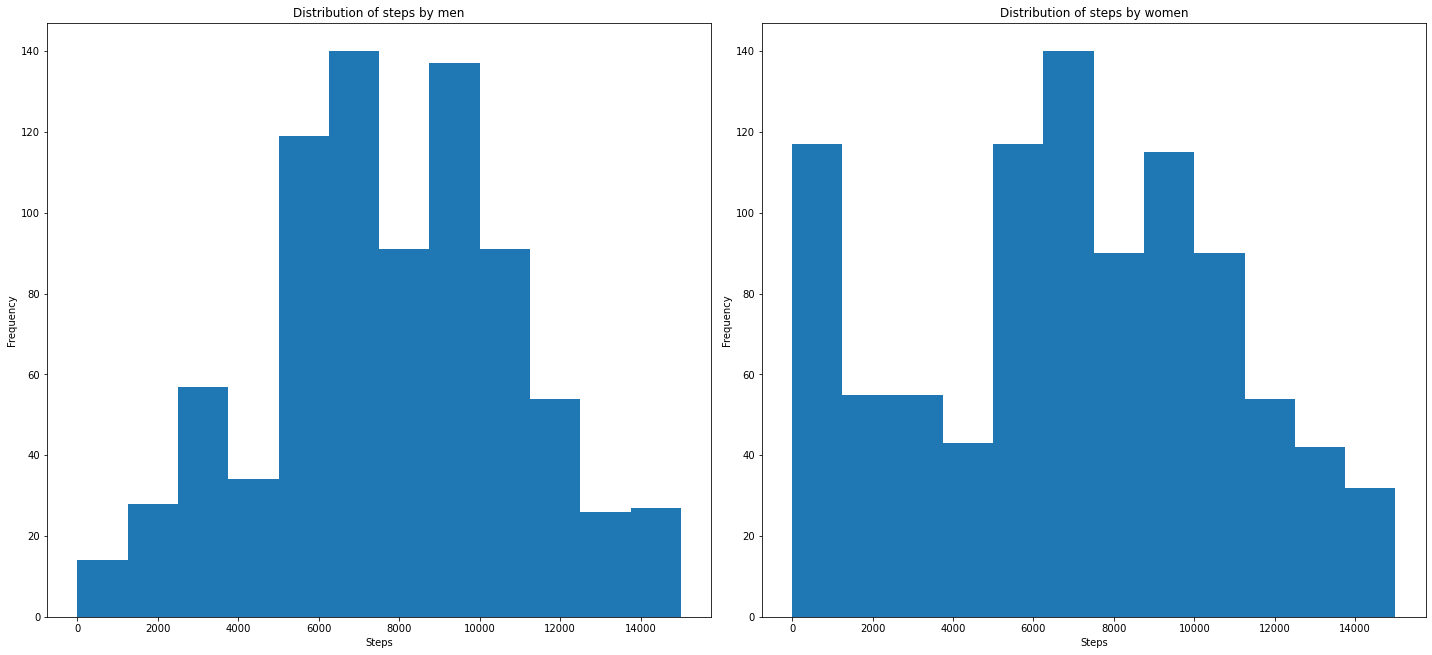

In [22]:
from scipy.stats import ttest_ind

male = data[data['data_set'] == 'male']
female = data[data['data_set'] == 'female']

male_stats = male.describe()
female_stats = female.describe()

diff_mean_steps = round(male_stats.at['mean', 'steps'] - female_stats.at['mean', 'steps'], 0)

ttest_steps = ttest_ind(male['steps'], female['steps'])
if ttest_steps[1] < 0.05:
    print("There is a significant difference in the average number of steps taken by men and women.")
else:
    print("There is no significant difference in the average number of steps taken by men and women.")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

min_steps_male = male['steps'].min()
max_steps_male = male['steps'].max()

axs[0].hist(male['steps'], bins = 12, range = (0, 15000))
axs[0].set_title('Distribution of steps by men')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Frequency')

min_steps_female = female['steps'].min()
max_steps_female = female['steps'].max()

axs[1].hist(female['steps'], bins = 12, range = (0, 15000))
axs[1].set_title('Distribution of steps by women')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Frequency')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We decided to go with 12 bins due to earlier mentioned calculations based on Struge's Rule's formula. The female histogram shows that women had more frequent steps between 0 and 1000 steps than men. Men do more steps in range from 9000 to 10000. Distribution of steps is visually very similar.

**Pretend you did not visualize the data yet. What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was?**

Without data visualization, we cannot tell if a data set is valid. Moreover, using different tests we cannot describe the data as well as when we visualize them. By using t-test we got p-value less than our threshold (0.05). We can reject the null hypothesis, which says that there is no significant difference in the average number of steps taken by men and women. We can support our conclusions based on the website we found where it says: "If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.", written on scipy.stats.ttest_ind. (2022). 

The point of the exercise was to see how we think and whether we know that visualization is important. Sometimes we make conclusions based on data and sources supporting it, but the data itself can still be wrong. Data visualization gives us a clear idea of what the information means by giving it visual context through graphs. This makes the data more natural for the human mind to comprehend and therefore makes it easier to identify trends, patterns, and outliers within large data sets.

**Scatter plots. Create a scatter plot with both data samples by using your own alternative to color='#f6756d' and color='#10bdc3'. Explain why you chose this visualization, its pros, and cons.**

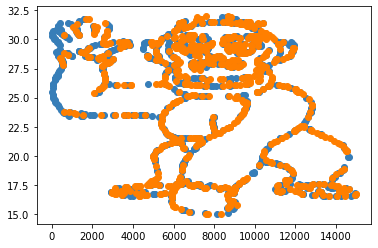

In [8]:
plt.scatter(x=female['steps'], y=female['bmi'], c='#377eb8')
plt.scatter(x=male['steps'], y=male['bmi'], c='#ff7f00')

Scatter plot shows correlations between variables, but it is hard to capture underlying distribution by it. It is challenging to plot more than two variables. Due to chosen colors, color blind people can see the results as well.

## Part 3: Different types of visualization from DAOST

The exercise below, is a selection of questions from Week 3, Part 2 and 3.

> *Exercise:*
>
> * *Questions from DAOST*
>     * Janert, the author of DAOST, is so suspicious of mean, median, and related summary statistics. Explain why one has to be careful when using those - and why visualization of the full data is always better. 
>     * Explain what is a box plot. When are box plots most useful? Are violin plots better or worse than box plots? Why?
> * *Recreating plots from DAOST*. We need some box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. We'll use data from the 15 focus crimes defined in Part 1.
>     * For the full time-span of the data, calulate the **number of crimes per day** within each category for the entire duration of the data.
>     * Create a box and whiskers plot showing the mean, median, quantiles, etc. for all 15 crime-types side-by-side. What does this plot reveal that you can't see in the plots from previous weeks?
>     * Now, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it: 
>        * For datapoint, the only thing you care about is the time-of-day, so discard everything else.
>        * You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. (Refer to Week 3 exercise 3.2 for hints.)      
>        * Now, you can create box-plots to create an overview of *when various crimes occur*. Note that these plot have quite a different interpretation than ones we created in the previous exercise. Comment your results. 

3.1.1: summary of summary statistics

The group takes the summary statistics (mean, std, variance, median, percentiles) and divides into two subgroups: 
- (mean, std, variance)
- (median, percentiles)

The first group (mean, standard deviation, variance) has a few assumptions. These are:
- symmetric, unimodal distribution 
- no outliers
However, in any real world dataset at least one of these assumptions are violated. Outliers can happen because an administrative error, malfunctioning sensor, or the very nature of the data. Once an outlier is established the mean value is distorted, and by consequence the standard deviation and variance as well. 

The second group (median, percentiles) are more robust against outliers, but it also has its own issues, but some of these issues can be solved. Such as using the cumulative distribution function to find at which element the value is over the percentile that we look for. Or, the book also states that historically mean based summary statistics were used, as it is more computationally expensive to use median based summary statistics. 

As to why visualizing the full data is often the simplest and most efficient solution, Anscombe's quartet can be an answer. The mean based summary statistics are proved to show the same values for wildly different datasets. However median based summary statistics seem to be a bit more robust against sets containing outliers.

3.1.2 box plots

Box plots are a handy plot type that is based on medians, quantiles, and interquantile ranges, to see value distribution, and outliers. The boxplot has several central pieces: 
- outliers: these points are falling outside of the nearest inter quartile range (iqr) multiplied by 1.5 
- whisker: the section that is between an iqr limit, and iqr*1.5 
- main box: the section of iqr. that is, from the 25th percentile to the 75th percentile. 
- line within the main box: the median value. 

Violin plots: these plots display all the information that boxplots display, and some extra other information. Such as: 
- capable to show multimodal peaks within the data by showing probability densities for a value. 

Due to this more nuanced differences can be picked up within the data than the boxplot can pick up on. Since the violinplot is strictly better than the boxplot, it is recommended to use it. 

3.2.1: For the full time-span of the data, calulate the number of crimes per day within each category for the entire duration of the data.

In [13]:
#3.2.1
maxSearch = datetime.datetime(2001, 5, 3)
minSearch = datetime.datetime(2021, 5, 3)

for item in pd.DatetimeIndex(police_incidence_reports['Date']):
    if (item > maxSearch):
        maxSearch = item

for item in pd.DatetimeIndex(police_incidence_reports['Date']):
    if (item < minSearch):
        minSearch = item

daysPast = (maxSearch - minSearch).days
daysPast

5613

First, the total number of days for the duration of the data set must be calculated. The earliest date is 2003 01 01, and the latest is 2018 05 15. A total of 5613 days have passed between these two dates, so this number will be used to find out how many crimes of one type happened on an average day.

In [17]:
#number of crimes per day per crime type: Obtain the amount of occurences then divide by the total amount days
#total days tracked: 

OccurenceOfFocusCrimesPerDay = []
for focuscrime in focuscrimes_set:
    focuscrimedftemp = police_incidence_reports['Category']== focuscrime
    avgFocuscrimePerDay = len(police_incidence_reports[focuscrimedftemp]) / daysPast
    OccurenceOfFocusCrimesPerDay.append([avgFocuscrimePerDay, focuscrime])
OccurenceOfFocusCrimesPerDay

[[2.939782647425619, 'PROSTITUTION'],
 [20.990735791911632, 'DRUG/NARCOTIC'],
 [1.7694637448779618, 'DISORDERLY CONDUCT'],
 [85.15499732763229, 'LARCENY/THEFT'],
 [1.7388205950472118, 'DRUNKENNESS'],
 [16.224300730447176, 'BURGLARY'],
 [22.488508818813468, 'VEHICLE THEFT'],
 [20.43791199002316, 'VANDALISM'],
 [3.7420274363085695, 'WEAPON LAWS'],
 [2.0399073579191165, 'STOLEN PROPERTY'],
 [9.703723499020132, 'ROBBERY'],
 [3.419561731694281, 'TRESPASS'],
 [1.0069481560662747, 'DRIVING UNDER THE INFLUENCE'],
 [29.759843221093888, 'ASSAULT']]

The above printed list shows the average number of times a particular focus crime occurs in a day. Some occur only once a day in the city, others up to 85 times.

3.2.2: 
Create a box and whiskers plot showing the mean, median, quantiles, etc. for all 15 crime-types side-by-side. What does this plot reveal that you can't see in the plots from previous weeks?

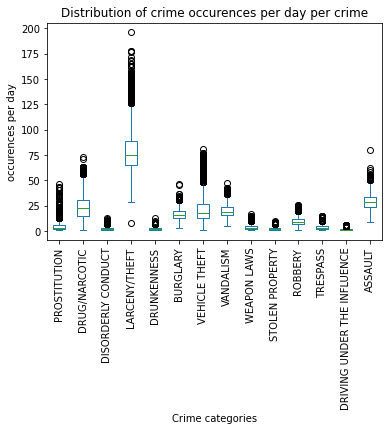

In [18]:
#get a dataframe that counts the amount of crimes on every day, for each crimetype. then boxplot it all
overallDataframe = pd.DataFrame()

for focuscrime in focuscrimes_set:
    focuscrimedftemp = police_incidence_reports['Category']== focuscrime
    focuscrimedf = police_incidence_reports[focuscrimedftemp]
    focuscrimeValueCounts = focuscrimedf['Date'].value_counts()
    overallDataframe[focuscrime] = focuscrimeValueCounts 

overallDataframe.plot.box()
plt.xlabel("Crime categories")
plt.ylabel("occurences per day")
plt.title("Distribution of crime occurences per day per crime")
plt.xticks(rotation=90)
plt.show()

In this boxplot, we have seen how many times a day the given crime happens most frequently. Contrary to means or other summary statistics, we can see how many outliers are there and (assuming) normal distribution how skewed it is. 

Task: 3.2.3: Now, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it:

For datapoint, the only thing you care about is the time-of-day, so discard everything else.

You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. (Refer to Week 3 exercise 3.2 for hints.)

Now, you can create box-plots to create an overview of when various crimes occur. Note that these plot have quite a different interpretation than ones we created in the previous exercise. Comment your results.

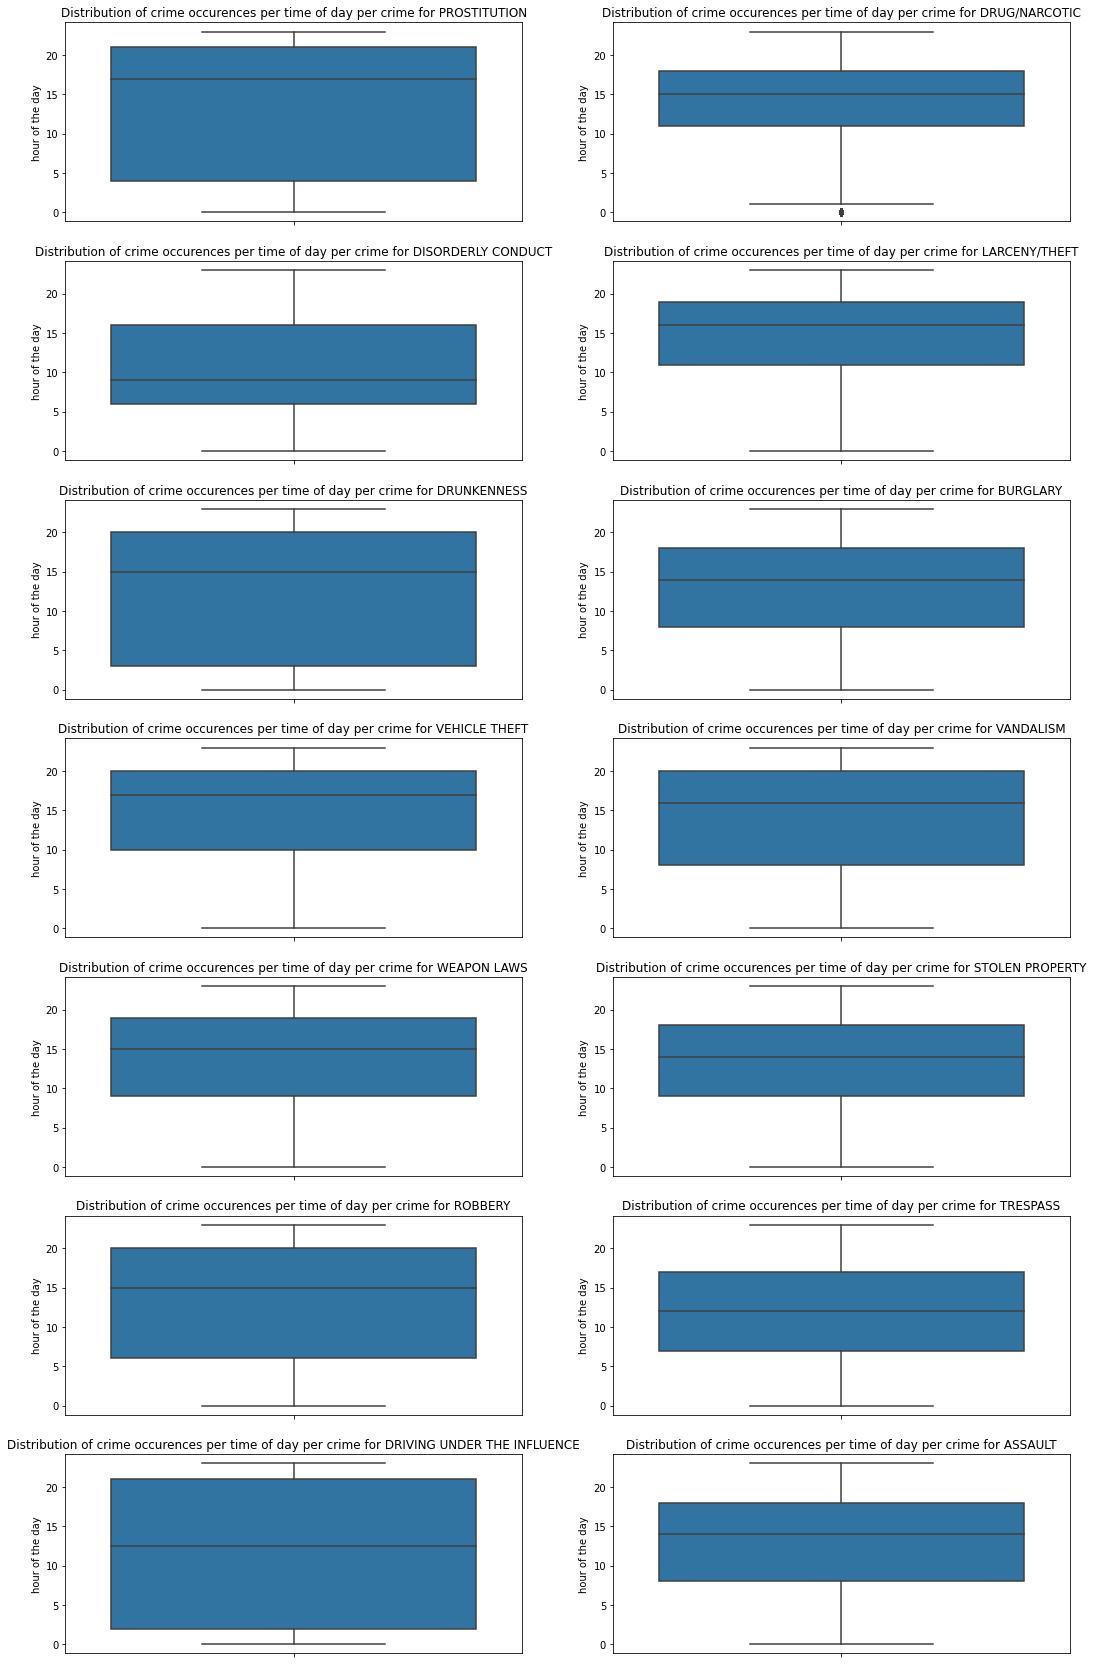

In [20]:
#get a dataframe that counts the amount of crimes on every day, for each crimetype. then boxplot it all
figure = plt.figure(figsize=(18,30))
counter = 1

for focuscrime in focuscrimes_set:
    #filter for focuscrime
    focuscrimedftemp = police_incidence_reports['Category']== focuscrime
    focuscrimedf = police_incidence_reports[focuscrimedftemp]
    
    figure.add_subplot(7,2,counter)
    #create a boxplot based on the occurence of hour values
    ax = sns.boxplot(y=focuscrimedf['Datetime'].dt.hour)
    plt.ylabel("hour of the day")
    plt.title("Distribution of crime occurences per time of day per crime for "+ focuscrime)
    plt.xticks(rotation=90)
    counter = counter + 1

plt.show()

In this plot, we get an idea about at what hour of the day a given crime happens most frequently. 

Note: The exercise does state that we should take into account that 1 hour does not equal 100 minutes, but only 60 minutes, but with the solution we have chosen (dividing events into hours) it is not relevant to treat the minute data differently, so this is not done.

This differs from the previous boxplot as we do not plot the number of crimes that occur in a day, but on the timing. 

## PART 4: Visualizing geo-data

Let's now use the cool Folium functionalites `HeatMap` and `HeatMapWithTime` to create a visualization of the patterns of your favorite crime-type and how they change over time. 

**Note** The exercise below is a mix of exercise 1.2 (**but with the data you choose**) and 1.3 from Week 4.

> *Exercise*: Heatmaps and heatmap movies. you get to make all the choices, but remember to **explain and motivate them**.
> * Start by choosing a crimetype with spatial patterns that change over time. Use your data-exploration from the previous lectures to choose a good one.
> * Create a heatmap by grabbing your crimetype data across all times. Play with parameters to get plots you like and explain why you chose them and what the effect of these parameters are.
> * Now, choose a time-resolution. You could plot daily, weekly, monthly datasets to plot in your movie. Again the goal is to find interesting temporal patterns to display. We want at least 20 frames though. Create the movie using `HeatMapWithTime`.
> * Comment on your results: 
>   - What patterns does your movie reveal?
>   - Motivate/explain the reasoning behind your choice of crimetype and time-resolution (you can also refer to exercises/visualizations that we have done in class to motivate your choice). 

We decided to stick with drug and narcotics offenses because Exercise 1.1 in Week 4 already showed a significant distribution across San Francisco, but we decided to do some additional analysis before creating the heat map movie. 

In [ ]:
# data preparation for crime type

lat_SF = 37.773972
lon_SF = -122.431297

drug_narcotic = police_incidence_reports.loc[police_incidence_reports['Category'].isin(['DRUG/NARCOTIC'])]\
    .sort_values(['Datetime']).reset_index()
drug_narcotic_August_2016 = drug_narcotic.loc[(drug_narcotic['Datetime'] >= '01-08-2016 00:00:00') &\
    (drug_narcotic['Datetime'] <= '31-08-2016 23:59:59')]

# Analysis of Heatmap Parameters

heatmap_SF_drug_narcotic = folium.Map(location=[lat_SF, lon_SF], tiles = "CartoDB Positron", zoom_start=13)
heat_data_drug_narcotic = [[row['Y'],row['X'],] for index, row in drug_narcotic.iterrows()]

plugins.HeatMap(heat_data_drug_narcotic, radius = 11, blur = 12,\
    gradient={0.1: 'darkblue', 0.28: 'cyan',0.46: 'lime', 0.64: 'yellow', 0.82: 'orange', 1: 'red'}).add_to(heatmap_SF_drug_narcotic)

heatmap_SF_drug_narcotic

We decided to reduce the radius from the default value of 25 to 11 to make spatial patterns visible as the overlap of the different points is reduced. Before the reduction, the area was just a single red area, but now the spread as well as the hotspots are visible.We continued trying to increase the visibility by reducing the blur from the default 15 to 12. Finally, we added your own gradient so that the edges are no longer so dominant and the transitions between the colors are clearer. We tried the other parameters like min_opacity, but we did not find any benefit as they affect the already balanced parameters, so we decided that adjusting radius, blur and the gradient is enough.

In [ ]:
# Reasoning for Crime Type geographically

drug_narcotic_map = folium.Map(location=[lat_SF, lon_SF],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=800,\
    control_scale=True)

marker_cluster = folium.plugins.MarkerCluster().add_to(drug_narcotic_map)

for index, row in drug_narcotic_August_2016.iterrows():
    folium.Marker([row['Y'], row['X']]).add_to(marker_cluster)
    
drug_narcotic_map


The map with the grouped markers shows that drug and narcotics offenses spread out significantly in August 2016. This could cause the hotspots to shift geographically from image to image, but one cannot be certain based on this map because the change over time is missing. It could still be the case that the crimes are evenly distributed throughout the day, so the hot spots remain in the same location. 

Text(0.5, 1.0, 'Drug and Narcotics Offenses in August 2016 by Day')

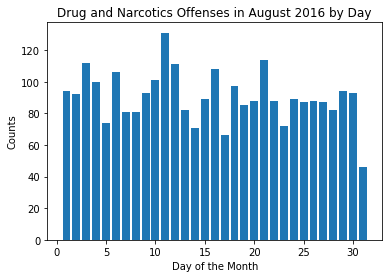

In [ ]:
# Heat Map Movie: Reasoning for Crime Type temporally

drug_narcotic_August_2016_day = drug_narcotic_August_2016.groupby([drug_narcotic_August_2016['Datetime'].dt.day]).agg({'PdId':'count'})\
    .sort_values(by=['Datetime']).rename(columns={'PdId':'Counts'}).reset_index()

plt.bar(x = drug_narcotic_August_2016_day['Datetime'] , height = drug_narcotic_August_2016_day['Counts'])
plt.xlabel('Day of the Month')
plt.ylabel('Counts')
plt.title('Drug and Narcotics Offenses in August 2016 by Day')


The bar chart of drug and narcotics offenses in August 2016 shows that there were a significant number of violations on each day of the month. This should prevent empty frames in the heatmap movie and could lead to some spread across the city, as there were least 40 offenses committed each day, but they could still be in the same locations, so the heatmaps would not change from frame to frame.

In [ ]:
# Heatmap Movie

ind = list(range(1,32))
drug_narcotic_heatmap_movie_August_2016 = folium.Map(location=[lat_SF, lon_SF],tiles = 'CartoDB Positron',zoom_start=12,width=800,height=800,\
    control_scale=True)
data_drug_narcotic_heatmap_movie_August_2016 = [ [ [row['Y'],row['X'] ] for index, row in \
    drug_narcotic_August_2016[drug_narcotic_August_2016['Datetime'].apply(lambda x: x.day==j)].iterrows() ] for j in ind ]

plugins.HeatMapWithTime(data_drug_narcotic_heatmap_movie_August_2016,index=ind).add_to(drug_narcotic_heatmap_movie_August_2016)
plugins.Fullscreen().add_to(drug_narcotic_heatmap_movie_August_2016)

drug_narcotic_heatmap_movie_August_2016

Most drug and narcotics crimes in August 2016 occurred in either the Tenderloin or the southern part of SoMa. Smaller temporal hotspots are in Bayview-Hunters Point, the northern part of Mission-Bernal Heights, and the western part of Haight at the entrance to Golden Gate Park. We found it quite surprising that there was no particular pattern in drug offenses on weekends. 

## Part 5: Errors in the data. 

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.
2. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.
3. And, during Week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

> *Exercise*: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below:
>
> * In each of the examples above, describe in your own words how the data-errors, I call attention to above, can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
> * Find your own example of human noise in the data and visualize it. Comment your results.

1. The graph shows the number of prostitution offenses within a week. There are seven continuously rising and falling local maximums indicating the different days of the week. The global maximum rises rather unnaturally, as there is no continuous rise or fall, so it seems rather strange why there is a significantly higher value at this certain time of the week. In this graph, the global maximum seems to be an outlier. If one chooses a smaller bin size such as the hour of the day, it is very likely that such an outlier will be hidden and disrupt the entire data set. If one did not plot the data and only extracted the time of maximum, decisions would be made based on a potential outlier. For example, this could lead to police focusing on prostitution at that time when they should be doing something else. As for the modeling, it is possible that any calculations using these data are wrong or have a bias toward a false trend. 

2. The jitter plot shows all larceny/ theft crimes between 7 and 8 pm. It is noticeable that most crimes are registered either at half or one of the full hours. More crimes than usual are also registered in 10- or 15-minute increments. The reason for this could be that police officers make rough estimates or round up to a nice number when recording crimes. It also depends on how the time of the crime is defined, because if it is the actual time, officers may arrive at the scene later, so they have to estimate when the crime occurred. It would not make sense to record a very specific time because it is only an estimate. This introduces a bias with respect to those specific times, since the algorithm only recognizes those patterns, so that, for example, in a regression to predict crimes, those times will have a higher probability. It is also not realistic to expect criminals in San Francisco to wait for a specific time before striking. 

3. The heatmap shows an hotspot for sex offences at the Hall of Justice. According to the City of San Francisco, the police department for sexual offences is located there as well, so maybe when people report a sexual crime at the department, this location is used (City and County of San Francisco, n.d.). This leads to the assumption that these crimes are happening in the department or Hall of Justice, which could be correct but is unlikely. Similar to the first problems, this potential false hotspot can lead to officers being sent to the wrong location and algorithms finding misleading patterns.

In [ ]:
# Find own human noise and visualize it

crime_records_lat_90_long_neg_120_point_5 = police_incidence_reports[(police_incidence_reports['Y'] == 90)\
    & (police_incidence_reports['X'] == -120.5)]

lat_SF = 37.773972
lon_SF = -122.431297

map_human_noise = folium.Map(location=[lat_SF, lon_SF], tiles = "Stamen Toner", zoom_start=1)
folium.Marker([lat_SF, lon_SF], popup='San Francisco').add_to(map_human_noise)
folium.Marker([90, -120.5], popup='Human Noise').add_to(map_human_noise)

map_human_noise

When we did exercise 3 in week 3, we already realized that something was wrong with the latitudes, since the value 90 does not make any sense in San Francisco, so we decided to exclude it. In week 4, we observed the same phenomenon when creating the heat maps. In the map above, a marker was placed in San Francisco and a sample marker was placed for latitude 90 and longitude -120.5 since this point is used for several crime records. We have no idea why this location was used over 140 times. If these outliers are not found before analysis, there will be a bias towards the north because these points are so far away, so some algorithms will weight them even more.

Bibliography:

City and County of San Francisco. (n.d.). Investigations 1: Sex Offender Unit | Police Commission. Sf.Gov. Retrieved February 27, 2022, from https://sfgov.org/policecommission/investigations-1-sex-offender-unit

SciPy Documentation. Retrieved February 28, 2022, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.